In [3]:
import numpy as np
import pandas as pd
from econml.grf import CausalForest, CausalIVForest, RegressionForest
from econml.dml import CausalForestDML
import scipy.special
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from dowhy import CausalModel
from IPython.display import Image, display
import plotly.figure_factory as ff
import seaborn as sns


In [4]:
#url = r"https://www.dropbox.com/s/up0k1i6btb8qmb7/usa_00006.csv?dl=1"
url = r"C:\Users\Krishna\Dropbox\usa_00007.csv"
data = pd.read_csv(url)
data.head()

,YEAR,SAMPLE,SERIAL,CBSERIAL,HHWT,CLUSTER,COUNTYFIP,METRO,STRATA,GQ,...,MARRINYR,RACE,RACED,EDUC,EDUCD,EMPSTAT,EMPSTATD,INCTOT,SEX_SP,AGE_SP
0,2010,201001,4,224,505.12,2010000000041,117,4,130001,1,...,1,1,100,10,101,1,10,28000,2.0,29.0
1,2010,201001,4,224,505.12,2010000000041,117,4,130001,1,...,1,1,100,7,71,1,10,45000,1.0,33.0
2,2010,201001,10,605,117.04,2010000000101,0,1,250001,1,...,1,1,100,6,63,3,30,19800,NaN,NaN
3,2010,201001,16,900,2168.32,2010000000161,0,0,80001,1,...,1,1,100,7,71,3,30,7400,1.0,38.0
4,2010,201001,16,900,2168.32,2010000000161,0,0,80001,1,...,1,1,100,6,64,1,10,50000,2.0,33.0


In [5]:
data.columns

Index(['YEAR', 'SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'COUNTYFIP',
       'METRO', 'STRATA', 'GQ', 'SSMC', 'PERNUM', 'PERWT', 'NCHILD', 'ELDCH',
       'SEX', 'AGE', 'MARST', 'MARRINYR', 'RACE', 'RACED', 'EDUC', 'EDUCD',
       'EMPSTAT', 'EMPSTATD', 'INCTOT', 'SEX_SP', 'AGE_SP'],
      dtype='object')

In [6]:
columns_to_drop = ['SAMPLE', 'SERIAL', 'CBSERIAL', 'HHWT', 'CLUSTER', 'STRATA', 'GQ', 
                    'PERNUM', 'PERWT','RACED', 'EDUCD', 'EMPSTATD']

data = data.drop(columns = columns_to_drop)
data.head()

,YEAR,COUNTYFIP,METRO,SSMC,NCHILD,ELDCH,SEX,AGE,MARST,MARRINYR,RACE,EDUC,EMPSTAT,INCTOT,SEX_SP,AGE_SP
0,2010,117,4,NaN,0,99,1,33,1,1,1,10,1,28000,2.0,29.0
1,2010,117,4,NaN,0,99,2,29,1,1,1,7,1,45000,1.0,33.0
2,2010,0,1,NaN,0,99,2,79,5,1,1,6,3,19800,NaN,NaN
3,2010,0,0,NaN,2,14,2,33,1,1,1,7,3,7400,1.0,38.0
4,2010,0,0,NaN,2,14,1,38,1,1,1,6,1,50000,2.0,33.0


In [7]:
data = data.dropna()

In [8]:
data["MARRINYR"].value_counts()
#married last year "yes" is value 2

1    1745551
0     111812
2      50179
Name: MARRINYR, dtype: int64

In [9]:
data['SEX_SP'] = data['SEX_SP'].astype(int)

"""
Creating the variable called 'same_sex_couple' from existing variables of SEX and SEX_SP
This variable is the treatment variable.
"""

data.loc[:, 'same_sex_couple'] = 0
data.loc[data['SEX'] == data['SEX_SP'], 'same_sex_couple'] = 1


In [10]:
data.shape

In [11]:
data = data[data["MARRINYR"] == 2] 
"""married year = 2 is the option which tells us that the
person married in the last year"""
data.shape

In [12]:
check_data = data[['SEX',
                    'SEX_SP',
                    'same_sex_couple']].copy()
check_data

,SEX,SEX_SP,same_sex_couple
1519212,2,1,0
1519213,1,2,0
1519360,1,2,0
1519361,2,1,0
1519606,1,2,0
...,...,...,...
5729927,2,1,0
5730010,2,1,0
5730011,1,2,0
5730059,1,2,0


In [13]:
temp_df = data[data["same_sex_couple"] == 1]
temp_df["YEAR"].shape

In [14]:
data = data[data["AGE"] > 18] 
data = data[data["MARST"] == 1]
data.loc[:, 'married_year'] = data["YEAR"] - 1
data.head()


,YEAR,COUNTYFIP,METRO,SSMC,NCHILD,ELDCH,SEX,AGE,MARST,MARRINYR,RACE,EDUC,EMPSTAT,INCTOT,SEX_SP,AGE_SP,same_sex_couple,married_year
1519212,2013,0,1,0.0,0,99,2,26,1,2,1,10,2,10000,1,31.0,0,2012
1519213,2013,0,1,0.0,0,99,1,31,1,2,1,6,1,35000,2,26.0,0,2012
1519360,2013,81,4,0.0,2,9,1,31,1,2,1,7,1,20000,2,34.0,0,2012
1519361,2013,81,4,0.0,2,9,2,34,1,2,1,11,2,18100,1,31.0,0,2012
1519606,2013,73,4,0.0,0,99,1,31,1,2,1,10,1,50000,2,25.0,0,2012


In [15]:
data.loc[data.ELDCH == 99, "ELDCH"] = 0
data.ELDCH

1519212     0
1519213     0
1519360     9
1519361     9
1519606     0
           ..
5729927    13
5730010     0
5730011     0
5730059    15
5730060    15
Name: ELDCH, Length: 49803, dtype: int64

In [16]:
data["married_year"].value_counts() #to understand how many people married in each year.

2014    7800
2015    7508
2016    7443
2017    7233
2018    7166
2013    6541
2012    6112
Name: married_year, dtype: int64

In [17]:
data.dtypes

YEAR                 int64
COUNTYFIP            int64
METRO                int64
SSMC               float64
NCHILD               int64
ELDCH                int64
SEX                  int64
AGE                  int64
MARST                int64
MARRINYR             int64
RACE                 int64
EDUC                 int64
EMPSTAT              int64
INCTOT               int64
SEX_SP               int32
AGE_SP             float64
same_sex_couple      int64
married_year         int64
dtype: object

In [18]:
features = ['SEX', 'RACE', 'EDUC', 'EMPSTAT', 'AGE'] #X
treatment ='same_sex_couple'#T
instrument ='INCTOT'  #W

In [19]:
data["outcome"] = (data["married_year"] > 2015).astype(int) #Y
outcome = 'outcome'

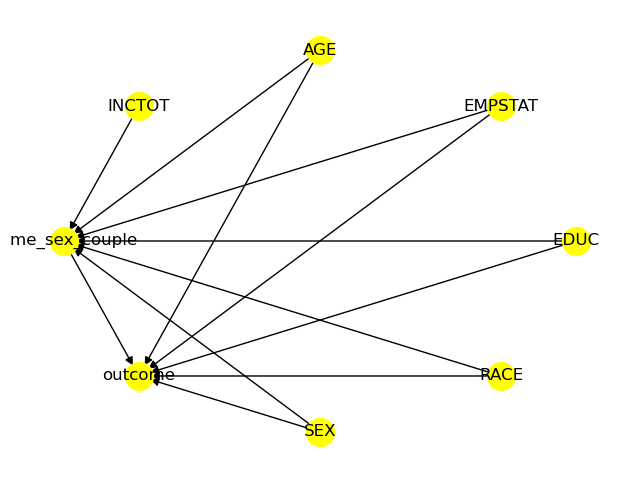

In [20]:
#causal graph with dowhy
model = CausalModel(
    data = data,
    treatment = treatment,
    outcome = outcome,
    common_causes = features,   
    instruments = instrument,
    effect_modifiers = None )
model.view_model()

In [21]:
train, test = train_test_split(data, test_size=0.2)

# set variables for causal forest Y=outcome, T=treatment, X=covariates, W=effect_modifiers 
Y = train[outcome]
T = train[treatment]
X = train[features]
W = train[instrument]
X_test = test[features]

In [22]:
from sklearn.linear_model import LassoCV
# set parameters for causal forest 
causal_forest = CausalForestDML(criterion='het', 
                                n_estimators=10000,       
                                min_samples_leaf=10, 
                                max_depth=None, 
                                max_samples=0.5,
                                discrete_treatment=False,
                                honest=True,
                                inference=True,
                                cv=10,
                                model_t=LassoCV(), 
                                model_y=LassoCV(),
                                )
                      


In [23]:
Y_array = Y.to_numpy().reshape(-1, 1)
T_array = T.to_numpy().reshape(-1, 1)
X_array = X.to_numpy()
W_array = W.to_numpy().reshape(-1, 1)


# fit train data to causal forest model 
causal_forest.fit(Y_array, T_array, X=X_array, W=W_array)
# estimate the CATE with the test set 
causal_forest.const_marginal_ate(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

array([[-0.08411324]])

In [24]:
# use causal forest model to estimate treatment effects  
treatment_effects = causal_forest.effect(X)
# calculate lower bound and upper bound confidence intervals 
lb, ub = causal_forest.effect_interval(X, alpha=0.05)

# convert arrays to pandas dataframes for plotting
te_df = pd.DataFrame(treatment_effects, columns=['cate'])
lb_df = pd.DataFrame(lb, columns=['lb'])
ub_df = pd.DataFrame(ub, columns=['ub'])

# merge dataframes and sort 
df = te_df.merge(lb_df, left_index=True, right_index=True, how='left')
df = df.merge(ub_df, left_index=True, right_index=True, how='left')
df.sort_values('cate', inplace=True, ascending=True)
df.reset_index(inplace=True, drop=True)
# calculate rolling mean
z = df.rolling(window=30, center=True).mean()

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


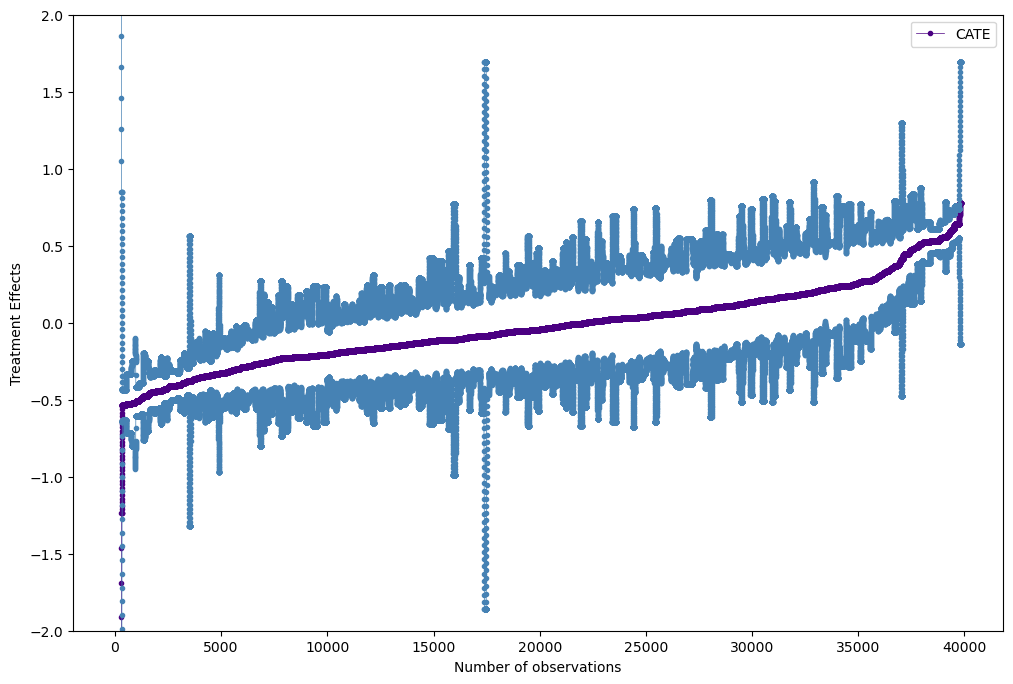

In [25]:
fig, ax = plt.subplots(figsize =(12, 8))
# plotlines for treatment effects and confidence intervals
ax.plot(z['cate'],
        marker='.', linestyle='-', linewidth=0.5, label='CATE', color='indigo')
ax.plot(z['lb'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
ax.plot(z['ub'],
        marker='.', linestyle='-', linewidth=0.5, color='steelblue')
# axes and create legend
ax.set_ylabel('Treatment Effects')
ax.set_xlabel('Number of observations')
ax.set_ylim(-2,2)
ax.legend()
fig.show()

In [30]:
X.shape, causal_forest.feature_importances()[0]

((39842, 5),
 array([0.05265692, 0.15033784, 0.23813836, 0.09893464, 0.45993224]))

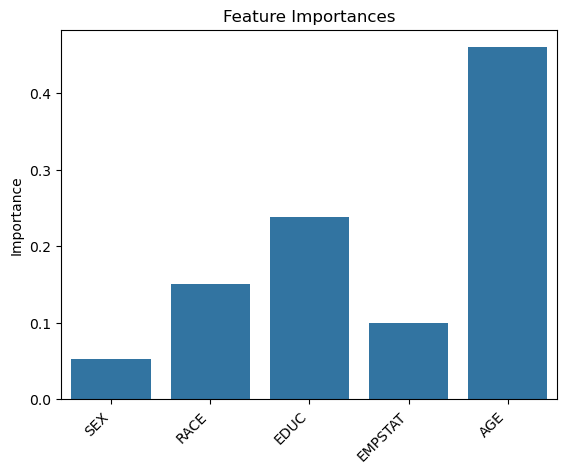

In [31]:
fig, ax = plt.subplots()
sns.barplot(x=X.columns , y=causal_forest.feature_importances()[0], color='C0').set(
    title='Feature Importances', ylabel='Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


In [ ]:
import shap
# fit causal forest with default parameters 
causal_forest = CausalForestDML()
causal_forest.fit(Y, T, X=X, W=W)

# calculate shap values of causal forest model 
shap_values = causal_forest.shap_values(X)
# plot shap values 
shap.summary_plot(shap_values['Y0']['T0'])

TypeError: __init__() got an unexpected keyword argument 'normalize'

In [ ]:
X = features
Y = outcome
T = treatment
W = instrument

X_train, X_test, y_train, y_test = train_test_split(
                                     X, Y, test_size=0.40, random_state=42)

In [ ]:
W

1586499    26
1586500    31
1586647    31
1586648    34
1586893    31
           ..
5403318    39
5403362    59
5403363    67
5403424    22
5403425    22
Name: AGE, Length: 45317, dtype: int64

In [ ]:
from sklearn.linear_model import LassoCV
est = CausalForestDML(criterion='mse', n_estimators=200, min_samples_leaf=10, 
                      max_depth=10, max_samples=0.5,
                      discrete_treatment=False,
                      model_t=LassoCV(), model_y=LassoCV())

In [ ]:
Y_array = Y.to_numpy().reshape(-1, 1)
T_array = T.to_numpy().reshape(-1, 1)
X_array = X.to_numpy()
W_array = W.to_numpy().reshape(-1, 1)
Y_array.shape, T_array.shape, X_array.shape, W_array.shape

In [ ]:
est.fit(Y_array, T_array, X=X_array, W=W_array)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [ ]:
treatment_effects = est.effect(X_test)
treatment_effects

array([[-0.06638113],
       [-0.06638113],
       [-0.55135837],
       ...,
       [ 0.0100265 ],
       [ 0.15299215],
       [ 0.07951087]])

In [ ]:
lb, ub = est.effect_interval(X_test, alpha=0.05)

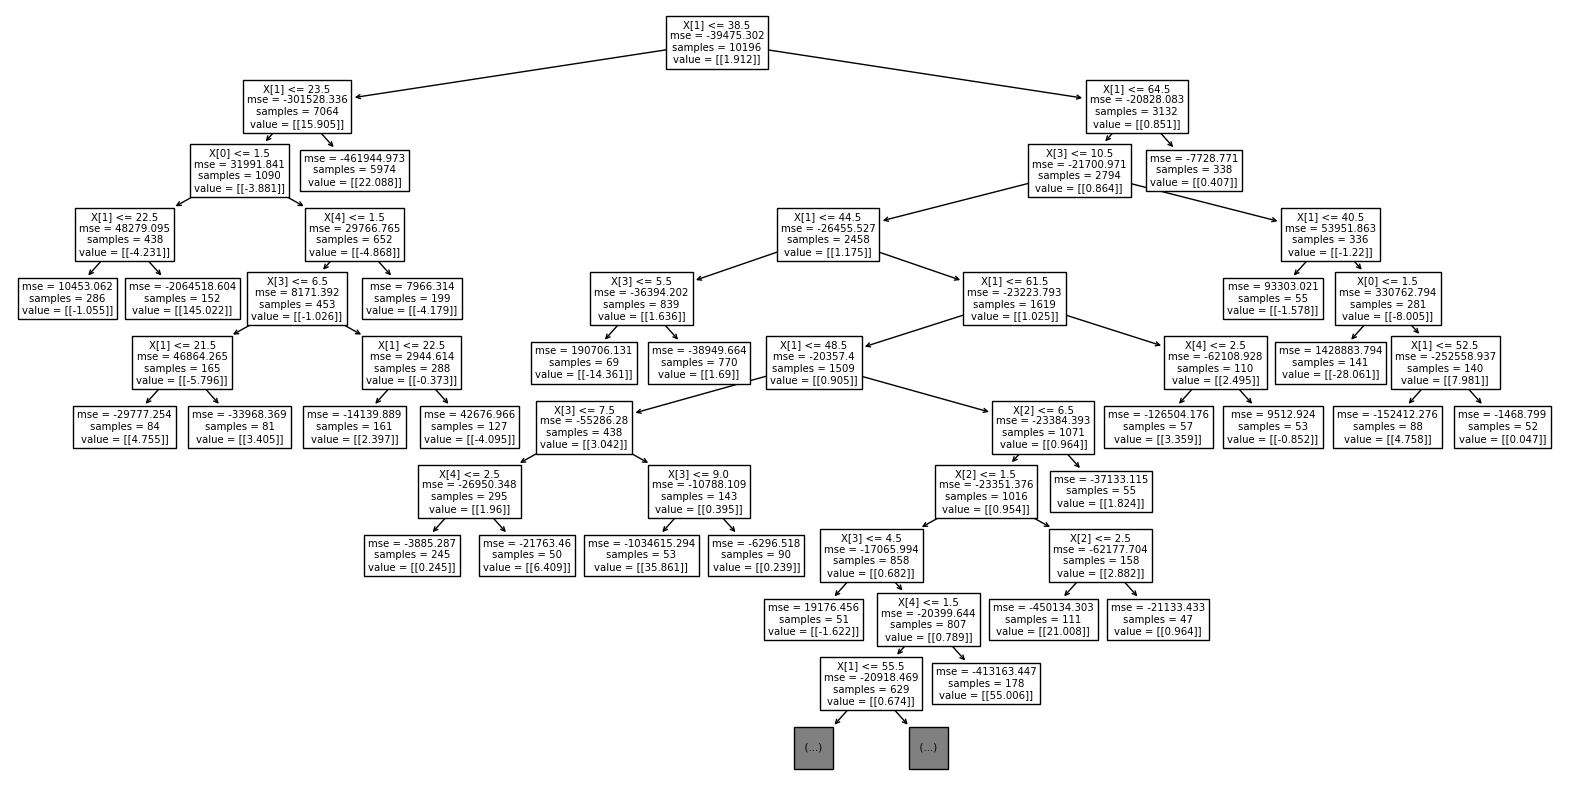

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(est[0], impurity=True, max_depth=10)
plt.show()

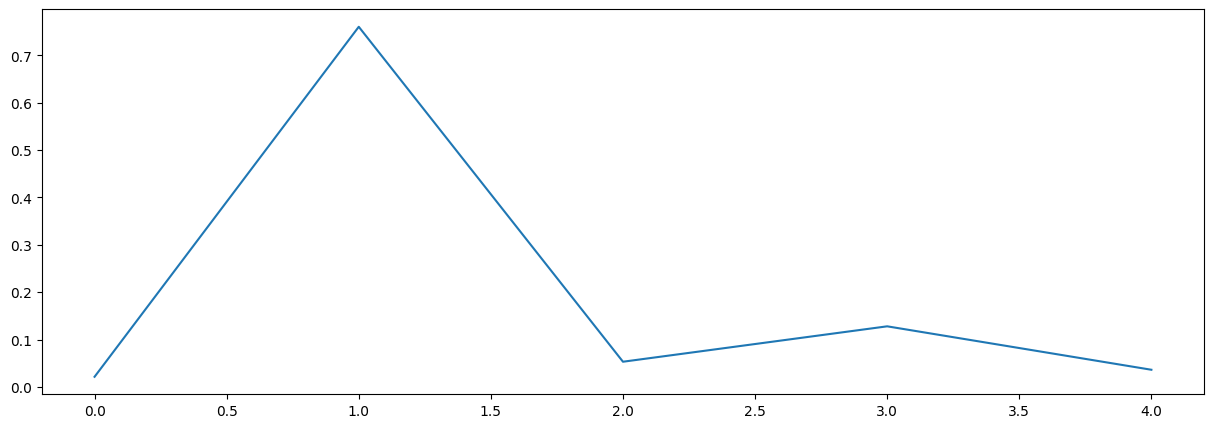

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(est.feature_importances(max_depth=4, depth_decay_exponent=2.0))
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


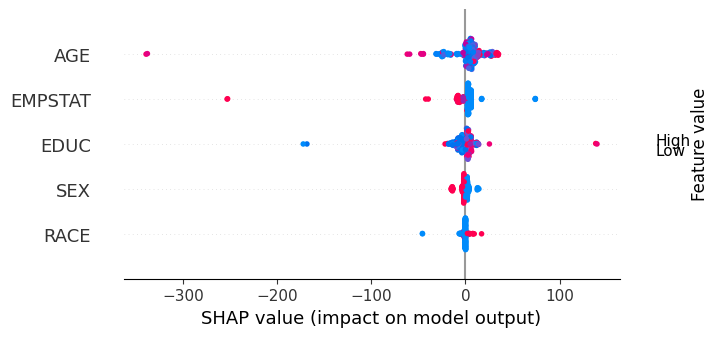

In [ ]:
import shap
explainer = shap.explainers.Tree(est, shap.maskers.Independent(X, max_samples=200))
shap_values = explainer(X[:250])
shap.plots.beeswarm(shap_values)


In [ ]:
shap.plots.beeswarm(shap_values[:, :, 100])
shap.plots.beeswarm(shap_values[:, :, 200])

IndexError: too many indices for array